<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Drought in the US<br>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  -<br>
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 30px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Illustration with Random Forests <br><br>
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      EAEE4000 - Fall 2022
  </div>

Note: The files were heavy. You can load first the "import modules" section and then directly go to "intermediary saving" in the preprocessing section.

### Import Modules

In [1]:
#based modules
import os
import numpy as np
import pandas as pd, copy, datetime
from time import time


#for the model random forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

#for visualization
from matplotlib import pyplot as plt

#evaluation
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [2]:
#for the NN

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

import netCDF4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2022-12-21 17:39:07.043915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_droughts = os.path.join(path_to_repo, "Droughts_Prediction", "data", "")

In [4]:
path_to_droughts

'/Users/emafagoul/Documents/Columbia/ML/Droughts_Prediction/data/'

In [5]:
path_to_train = '{}train_timeseries.csv'.format(path_to_droughts)
path_to_valid = '{}validation_timeseries.csv'.format(path_to_droughts)
path_to_test = '{}test_timeseries.csv'.format(path_to_droughts)
print(path_to_train)
print(path_to_valid)
print(path_to_test)

/Users/emafagoul/Documents/Columbia/ML/Droughts_Prediction/data/train_timeseries.csv
/Users/emafagoul/Documents/Columbia/ML/Droughts_Prediction/data/validation_timeseries.csv
/Users/emafagoul/Documents/Columbia/ML/Droughts_Prediction/data/test_timeseries.csv


# Data Inspection

### About the dataset and the study

We will be looking at the US Drought Prediction Kaggle Competition:

https://www.kaggle.com/datasets/cdminix/us-drought-meteorological-data

The US drought monitor is a measure of drought across the US manually created by experts using a wide range of data.

For this competition, we are predicting the US Drought Monitor Indicator for each US county. This is a classification problem over six levels of drought.

### Import the data

In [ ]:
df_train = pd.read_csv(path_to_train, low_memory = False)
df_valid = pd.read_csv(path_to_valid, low_memory = False)
df_test = pd.read_csv(path_to_test,low_memory = False)

In [ ]:
df_raw=pd.concat([pd.concat([df_train,df_valid]),df_test])

### Look at the data

In [ ]:
df_raw.head()

In [ ]:
df_raw.tail()

In [ ]:
df_raw.shape

In [ ]:
df_raw.describe()

In [ ]:
df_raw.dtypes

In [ ]:
df_raw.isna().sum()

**The key fields in the data frame are:**
-	fips: the unique identifier of a US County
-	score: the US Drought Monitor Indicator (the value to predict). There are 6 levels of drought.
-	date: the date the weather data were collected

**Summary of the initial findings:**
-	There are 23,841,468 rows (entries) and 21 columns (features)
-	There are missing values only for score feature, as the level of drought is given weekly. There is no missing value for the other columns
-	The date is in the object type. We'll have to format it into a datetime object to be able to work with it. The other columns are in correct format

# Data Preprocessing

Preprocessing steps:
* Fixing the date column by converting it to a datetime type.
* Creating new columns from the date column to enrich our data.
* Fixing our missing values
* Splitting by date and climate zone
* Normalization

### Convert date times

To transform our date column into datetime data type, we will use the parse_dates parameter to turn it into real datetime type. So, we'll load the data again but this time, we'll parse dates.

In [ ]:
df_train = pd.read_csv(path_to_train, low_memory = False, parse_dates = ["date"])
df_valid = pd.read_csv(path_to_valid, low_memory = False, parse_dates = ["date"])
df_test = pd.read_csv(path_to_test,low_memory = False, parse_dates = ["date"])

In [ ]:
df_new=pd.concat([pd.concat([df_train,df_valid]),df_test])

In [ ]:
#check
df_new.date.head(10)

### Create new columns

The prediction we want to achieve is a time-based forecasting. Thus, the most information we have on the dates, the best our algorithm can learn.

We will add some information on the dates, based on the column 'date'.

In [ ]:
# New colums
df_new['Year'] = df_new.date.dt.year
df_new['Month'] = df_new.date.dt.month
df_new['Week'] = df_new.date.dt.week
df_new['Day'] = df_new.date.dt.day
df_new["Day_of_year"] = df_new.date.dt.dayofyear

# Let's confirm the changes
df_new.head()

In [ ]:
print(df_new.shape)

In [ ]:
# Drop date
df_new.drop("date", axis=1, inplace=True)

In [ ]:
df_new.columns

### Delete missing values

The only missing values are in the score feature.
We are told that the missing values are because the level of drought is provided weekly.
As drought is long-term process, we can safely assume that the level of drought remain stable trought the week.

We delete the missing values and only keep lines with the weekly results

In [ ]:
df_new.dropna(inplace=True)

In [ ]:
df_new['score']

### Intermediary saving

In [ ]:
#not to reload from scratch because de files are heavy
df_new.to_csv('clean_data.csv')

In [6]:
path_to_final = '{}clean_data.csv'.format(path_to_droughts)
data = pd.read_csv(path_to_final, low_memory = False)

In [7]:
data.drop('Unnamed: 0',axis=1,inplace=True)

### Add Climate Zone

We split the data by climate zone, as we want to focus on Hot Climate. To do so we use another dataset found on GitHub:
https://gist.github.com/philngo/d3e251040569dba67942

In [9]:
path_to_zones = '{}climate_zones.csv'.format(path_to_droughts)
df_zones=pd.read_csv(path_to_zones,low_memory = False)
df_zones.head()

,State,State FIPS,County FIPS,IECC Climate Zone,IECC Moisture Regime,BA Climate Zone,County Name
0,AK,2,13,7,NaN,Very Cold,Aleutians East
1,AK,2,16,7,NaN,Very Cold,Aleutians West
2,AK,2,20,7,NaN,Very Cold,Anchorage
3,AK,2,50,8,NaN,Subarctic,Bethel
4,AK,2,60,7,NaN,Very Cold,Bristol Bay


In [10]:
#We uniformize the Fips Code to have a unique identifier between the 2 datasets

for i in range(len(df_zones['County FIPS'])-1):
    if len(str(df_zones.loc[i,'County FIPS']))==2:
        df_zones.loc[i,'County FIPS']='0'+str(df_zones.loc[i,'County FIPS'])
    if len(str(df_zones.loc[i,'County FIPS']))==1:
        df_zones.loc[i,'County FIPS']='00'+str(df_zones.loc[i,'County FIPS'])

In [11]:
#We create a new fips column

df_zones['fips']= df_zones['State FIPS'].astype(str)+df_zones['County FIPS'].astype(str)
df_zones['fips']=df_zones['fips'].astype(int)

In [12]:
#We merge on fips with the main dataframe

data=data.merge(df_zones[['BA Climate Zone','fips']],on='fips')

In [13]:
data.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,Year,Month,Week,Day,Day_of_year,BA Climate Zone
0,1001,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,15.92,...,9.31,3.74,5.58,1.0,2000,1,1,4,4,Hot-Humid
1,1001,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,13.16,...,6.38,1.71,4.67,2.0,2000,1,2,11,11,Hot-Humid
2,1001,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,9.06,...,6.40,3.84,2.55,2.0,2000,1,3,18,18,Hot-Humid
3,1001,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,11.11,...,8.03,3.96,4.07,2.0,2000,1,4,25,25,Hot-Humid
4,1001,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,15.23,...,6.38,1.27,5.11,1.0,2000,2,5,1,32,Hot-Humid


### Splitting

In [14]:
df=data.copy()

In [15]:
df_hot=df[(df['BA Climate Zone']=='Hot-Dry') | (df['BA Climate Zone']=='Hot-Humid')]

We split our data into training, validation and test.
- **Training set**: Data through the end of 2016 in Hot climate
- **Validation set**: Data from January 1, 2017 to December 31, 2018 in Hot climate
- **Test set**: Data from January 1, 2019 to December 31, 2020 in Hot Climate

In [20]:
df_train = df_hot[df_hot.Year <2017]
df_val = df_hot[(2017 <= df_hot.Year) & (df_hot.Year<2019)]
df_test = df_hot[(2019 <= df_hot.Year)]

len(df_train), len(df_val), len(df_test)

(484302, 56784, 57330)

In [21]:
df_train.loc[:,'score']=df_train['score'].round().astype(int).astype("category")
df_val.loc[:,'score']=df_val['score'].round().astype(int).astype("category")
df_test.loc[:,'score']=df_test['score'].round().astype(int).astype("category")

/var/folders/2g/7m1dzwts2xndbnmd_36crr8r0000gn/T/ipykernel_5990/2566056671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:,'score']=df_train['score'].round().astype(int).astype("category")
/var/folders/2g/7m1dzwts2xndbnmd_36crr8r0000gn/T/ipykernel_5990/2566056671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:,'score']=df_val['score'].round().astype(int).astype("category")
/var/folders/2g/7m1dzwts2xndbnmd_36crr8r0000gn/T/ipykernel_5990/2566056671.py:3: SettingWithCopyWarn

In [23]:
# Split data into X and y

X_train_df, y_train_df = df_train.drop(["score","BA Climate Zone"], axis=1), df_train.score
X_valid_df, y_valid_df = df_val.drop(["score","BA Climate Zone"], axis=1), df_val.score
X_test_df, y_test_df = df_test.drop(["score","BA Climate Zone"], axis=1), df_test.score


# Check the shape of our X and y variables
X_train_df.shape, y_train_df.shape, X_valid_df.shape, y_valid_df.shape,X_test_df.shape, y_test_df.shape

((484302, 24), (484302,), (56784, 24), (56784,), (57330, 24), (57330,))

### Normalization

In [25]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df = (X_train_df - mean)/std
X_valid_df = (X_valid_df - mean)/std
X_test_df  = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

X_valid = X_valid_df.to_numpy()
y_valid = y_valid_df.to_numpy()

X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()


X_train.shape,y_train.shape,X_valid.shape,y_valid.shape, X_test.shape,y_test.shape

((484302, 24), (484302,), (56784, 24), (56784,), (57330, 24), (57330,))

# Evaluation metric

In [26]:
def print_valid_score(m, X_train, y_train, X_valid, y_valid):
    
    print('Accuracy on train set: {:.4f}'.format(accuracy_score(m.predict(X_train), y_train)))
    print('Accuracy on valid set: {:.4f}'.format(accuracy_score(m.predict(X_valid), y_valid)))
    
    print('\nRecall on train set: {:.4f}'.format(recall_score(m.predict(X_train), y_train,average='weighted',zero_division=1)))
    print('Recall on valid set: {:.4f}'.format(recall_score(m.predict(X_valid), y_valid,average='weighted',zero_division=1)))

    print('\nPrecision on train set: {:.4f}'.format(precision_score(m.predict(X_train), y_train,average='weighted')))
    print('Precision on valid set: {:.4f}'.format(precision_score(m.predict(X_valid), y_valid,average='weighted')))

    print('\nF1 Score on train set: {:.4f}'.format(f1_score(m.predict(X_train), y_train,average='weighted')))
    print('F1 Score on valid set: {:.4f}'.format(f1_score(m.predict(X_valid), y_valid,average='weighted')))
    return

In [27]:
def print_score(m,X_train, y_train, X_test, y_test):
    
    print('Accuracy on train set: {:.4f}'.format(accuracy_score(m.predict(X_train), y_train)))
    print('Accuracy on test set: {:.4f}'.format(accuracy_score(m.predict(X_test), y_test)))
    
    print('\nRecall on train set: {:.4f}'.format(recall_score(m.predict(X_train), y_train,average='weighted',zero_division=1)))
    print('Recall on test set: {:.4f}'.format(recall_score(m.predict(X_test), y_test,average='weighted',zero_division=1)))

    print('\nPrecision on train set: {:.4f}'.format(precision_score(m.predict(X_train), y_train,average='weighted')))
    print('Precision on test set: {:.4f}'.format(precision_score(m.predict(X_test), y_test,average='weighted')))

    print('\nF1 Score on train set: {:.4f}'.format(f1_score(m.predict(X_train), y_train,average='weighted')))
    print('F1 Score on test set: {:.4f}'.format(f1_score(m.predict(X_test), y_test,average='weighted')))
    return

# Baseline model - Vanilla Neural Network Model

I trained a vanilla Neural Network Model from scratch to predict drought level in Counties with a hot climate. This a base line model. 

In [28]:
y_train=y_train.reshape(484302,1)
y_valid=y_valid.reshape(56784,1)
y_test=y_test.reshape(57330,1)

In [29]:
# set hyperparameters
n_neuron       = 50
activation     = 'relu'
num_epochs     = 40
learning_rate  = 0.0001
minibatch_size = 64

In [30]:
nn_model = Sequential()

nn_model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
nn_model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
nn_model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
nn_model.add(Dense(y_train.shape[1],  activation='softmax')) # the output layer


nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

2022-12-21 17:48:45.785698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_acc', patience=20)


history = nn_model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    verbose         = 1,
                    validation_data=(X_valid,y_valid),
                    callbacks       = [early_stop])

Epoch 1/40
7568/7568 [==============================] - 6s 713us/step - loss: 0.0000e+00 - acc: 0.1719 - val_loss: 0.0000e+00 - val_acc: 0.2010
Epoch 2/40
7568/7568 [==============================] - 6s 774us/step - loss: 0.0000e+00 - acc: 0.1719 - val_loss: 0.0000e+00 - val_acc: 0.2010
Epoch 3/40
7568/7568 [==============================] - 5s 707us/step - loss: 0.0000e+00 - acc: 0.1719 - val_loss: 0.0000e+00 - val_acc: 0.2010
Epoch 4/40
7568/7568 [==============================] - 6s 737us/step - loss: 0.0000e+00 - acc: 0.1719 - val_loss: 0.0000e+00 - val_acc: 0.2010
Epoch 5/40
7568/7568 [==============================] - 6s 729us/step - loss: 0.0000e+00 - acc: 0.1719 - val_loss: 0.0000e+00 - val_acc: 0.2010
Epoch 6/40
7568/7568 [==============================] - 6s 737us/step - loss: 0.0000e+00 - acc: 0.1719 - val_loss: 0.0000e+00 - val_acc: 0.2010
Epoch 7/40
7568/7568 [==============================] - 5s 708us/step - loss: 0.0000e+00 - acc: 0.1719 - val_loss: 0.0000e+00 - val_acc:

In [32]:
print_valid_score(nn_model, X_train, y_train, X_valid, y_valid)

15135/15135 [==============================] - 6s 379us/step
Accuracy on train set: 0.1719
1775/1775 [==============================] - 1s 367us/step
Accuracy on valid set: 0.2010
15135/15135 [==============================] - 6s 367us/step

Recall on train set: 0.1719
1775/1775 [==============================] - 1s 367us/step
Recall on valid set: 0.2010
15135/15135 [==============================] - 6s 412us/step

Precision on train set: 1.0000
1775/1775 [==============================] - 1s 382us/step
Precision on valid set: 1.0000
15135/15135 [==============================] - 6s 382us/step

F1 Score on train set: 0.2934
1775/1775 [==============================] - 1s 380us/step
F1 Score on valid set: 0.3347


In [33]:
print_score(nn_model,X_train, y_train, X_test, y_test)

15135/15135 [==============================] - 6s 379us/step
Accuracy on train set: 0.1719
1792/1792 [==============================] - 1s 388us/step
Accuracy on test set: 0.1810
15135/15135 [==============================] - 6s 372us/step

Recall on train set: 0.1719
1792/1792 [==============================] - 1s 369us/step
Recall on test set: 0.1810
15135/15135 [==============================] - 6s 368us/step

Precision on train set: 1.0000
1792/1792 [==============================] - 1s 371us/step
Precision on test set: 1.0000
15135/15135 [==============================] - 6s 371us/step

F1 Score on train set: 0.2934
1792/1792 [==============================] - 1s 375us/step
F1 Score on test set: 0.3066


# Fine-tuned Random Forest

In [29]:
y_train=y_train.reshape(484302,)
y_valid=y_valid.reshape(56784,)
y_test=y_test.reshape(57330,)

## Pre fine tuning tests

##### Testing number of trees

In [ ]:
model = RandomForestClassifier(n_estimators = 10, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 30, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 70, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

##### Testing min_samples_leaf

In [ ]:
model = RandomForestClassifier(n_estimators = 50,min_samples_leaf = 3, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50,min_samples_leaf = 5, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50,min_samples_leaf = 10, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50,min_samples_leaf = 20, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

##### testing max_depth

In [ ]:
model = RandomForestClassifier(n_estimators = 50, max_depth=2, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50, max_depth=4, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50, max_depth=5, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50, max_depth=7, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50, max_depth=10, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

In [ ]:
model = RandomForestClassifier(n_estimators = 50, max_depth=20, n_jobs = -1, random_state = 42)
model.fit(X_train,y_train)
print_score(model, X_train, y_train, X_valid, y_valid)

## Parameter Grid

In [30]:
random_grid1 = {'n_estimators': [15,20,30,45,60],
               'max_features':[None,'sqrt'], 
               'max_depth':[None,10, 20, 25],
               'min_samples_leaf':[3,7,10,16],
               'max_samples':[None,0.5,0.25],
               'min_samples_split':[2,5,10,15,25],           
             }

In [31]:
class1 = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator = class1, param_distributions = random_grid1, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)

%time rf_drought = rf_random.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_drought.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=25, max_features=None, max_samples=0.5, min_samples_leaf=10, min_samples_split=15, n_estimators=30; total time= 2.9min
[CV] END max_depth=None, max_features=None, max_samples=0.5, min_samples_leaf=16, min_samples_split=25, n_estimators=20; total time= 1.7min
CPU times: user 15.6 s, sys: 547 ms, total: 16.2 s
Wall time: 9min 50s
The best hyperparameters: 
 {'n_estimators': 60, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_samples': 0.25, 'max_features': 'sqrt', 'max_depth': 10}


In [32]:
model_rf = rf_drought.best_estimator_
model_rf

RandomForestClassifier(max_depth=10, max_features='sqrt', max_samples=0.25,
                       min_samples_leaf=10, min_samples_split=15,
                       n_estimators=60, random_state=42)

In [96]:
print_valid_score(model_rf, X_train, y_train, X_valid, y_valid)

Accuracy on train set: 0.5554
Accuracy on valid set: 0.6133

Recall on train set: 0.5554
Recall on valid set: 0.6133

Precision on train set: 0.9023
Precision on valid set: 0.9625

F1 Score on train set: 0.6615
F1 Score on valid set: 0.7461


In [97]:
print_score(model_rf, X_train, y_train, X_test, y_test)

Accuracy on train set: 0.5554
Accuracy on test set: 0.6378

Recall on train set: 0.5554
Recall on test set: 0.6378

Precision on train set: 0.9023
Precision on test set: 0.9477

F1 Score on train set: 0.6615
F1 Score on test set: 0.7588


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names=[0,1,2,3,4,5]

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", "true")]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_rf,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

# Random Forest - Dealing with unbalance

## Under-sampling

In [85]:
np.unique(y_train,return_counts=True)

(array([0, 1, 2, 3, 4, 5]),
 array([241895,  83261,  64459,  49965,  29646,  15076]))

In [86]:
from imblearn.under_sampling import RandomUnderSampler

In [87]:
rus=RandomUnderSampler(sampling_strategy='auto',random_state=42)
X_train_new,y_train_new=rus.fit_resample(X_train,y_train)
print(X_train_new.shape,y_train_new.shape)

(90456, 24) (90456,)


In [88]:
# Standardization
mean, std = X_train_new.mean(), X_train_new.std()

X_train_new = (X_train_new - mean)/std
X_valid = (X_valid - mean)/std
X_test  = (X_test - mean)/std
X_newtest  = (X_newtest - mean)/std

In [89]:
random_grid2 = {'n_estimators': [70,100,110],
               'max_features':[None,'sqrt'], 
               'max_depth':[None,10, 20, 25],
               'min_samples_leaf':[3,7,10,16],
               'max_samples':[None,0.5,0.25],
               'min_samples_split':[2,5,10,15,25],           
             }

In [90]:
class2 = RandomForestClassifier(random_state=42)

rf_random2 = RandomizedSearchCV(estimator = class2, param_distributions = random_grid2, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)

%time rf_drought2 = rf_random2.fit(X_train_new,y_train_new)

print("The best hyperparameters: \n",rf_drought2.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 14.5 s, sys: 288 ms, total: 14.8 s
Wall time: 1min 12s
The best hyperparameters: 
 {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': None}


In [91]:
model_rf_balancedcat = rf_drought2.best_estimator_
model_rf_balancedcat

RandomForestClassifier(max_features='sqrt', min_samples_leaf=7, n_estimators=70,
                       random_state=42)

In [98]:
print_valid_score(model_rf_balancedcat, X_train_new, y_train_new, X_valid, y_valid)

Accuracy on train set: 0.8830
Accuracy on valid set: 0.5133

Recall on train set: 0.8830
Recall on valid set: 0.5133

Precision on train set: 0.8852
Precision on valid set: 0.5944

F1 Score on train set: 0.8836
F1 Score on valid set: 0.5394


In [99]:
print_score(model_rf_balancedcat, X_train_new, y_train_new, X_test, y_test)

Accuracy on train set: 0.8830
Accuracy on test set: 0.5270

Recall on train set: 0.8830
Recall on test set: 0.5270

Precision on train set: 0.8852
Precision on test set: 0.5486

F1 Score on train set: 0.8836
F1 Score on test set: 0.5358


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names=[0,1,2,3,4,5]

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", "true")]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_rf_balancedcat,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

## Over-sampling

In [101]:
from imblearn.over_sampling import SMOTE

In [102]:
smote=SMOTE(sampling_strategy='auto',random_state=42)
X_train_new,y_train_new=smote.fit_resample(X_train,y_train)
print(X_train_new.shape,y_train_new.shape)

(1451370, 24) (1451370,)


In [103]:
# Standardization
mean, std = X_train_new.mean(), X_train_new.std()

X_train_new = (X_train_new - mean)/std
X_valid = (X_valid - mean)/std
X_test  = (X_test - mean)/std
X_newtest  = (X_newtest - mean)/std

In [104]:
random_grid2 = {'n_estimators': [20,40,50,70],
               'max_features':[None,'sqrt'], 
               'max_depth':[None,10, 20, 25],
               'min_samples_leaf':[3,7,10,16],
               'max_samples':[None,0.5,0.25],
               'min_samples_split':[2,5,10,15,25],           
             }

In [105]:
class2 = RandomForestClassifier(random_state=42)

rf_random2 = RandomizedSearchCV(estimator = class2, param_distributions = random_grid2, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)

%time rf_drought2 = rf_random2.fit(X_train_new,y_train_new)

print("The best hyperparameters: \n",rf_drought2.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 1min 12s, sys: 764 ms, total: 1min 13s
Wall time: 7min 27s
The best hyperparameters: 
 {'n_estimators': 20, 'min_samples_split': 15, 'min_samples_leaf': 16, 'max_samples': 0.5, 'max_features': 'sqrt', 'max_depth': None}


In [106]:
model_rf_balancedcat = rf_drought2.best_estimator_
model_rf_balancedcat

RandomForestClassifier(max_features='sqrt', max_samples=0.5,
                       min_samples_leaf=16, min_samples_split=15,
                       n_estimators=20, random_state=42)

In [107]:
print_valid_score(model_rf_balancedcat, X_train_new, y_train_new, X_valid, y_valid)

Accuracy on train set: 0.8762
Accuracy on valid set: 0.5319

Recall on train set: 0.8762
Recall on valid set: 0.5319

Precision on train set: 0.8774
Precision on valid set: 0.6317

F1 Score on train set: 0.8767
F1 Score on valid set: 0.5731


In [108]:
print_valid_score(model_rf_balancedcat, X_train_new, y_train_new, X_valid, y_valid)

Accuracy on train set: 0.8762
Accuracy on valid set: 0.5319

Recall on train set: 0.8762
Recall on valid set: 0.5319

Precision on train set: 0.8774
Precision on valid set: 0.6317

F1 Score on train set: 0.8767
F1 Score on valid set: 0.5731


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names=[0,1,2,3,4,5]

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", "true")]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_rf_balancedcat,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()

# Random Forest with feature selection

In [36]:
def rf_feat_importance(model, df):
    feat_importance = pd.DataFrame({
        'cols': df.columns, 
        'imp': model.feature_importances_,
    })
    feat_importance = feat_importance.sort_values('imp', ascending = False)
    return feat_importance

In [38]:
feat_importance = rf_feat_importance(model_rf, X_train_df)
feat_importance[:20]

,cols,imp
19,Year,0.255081
9,T2M_RANGE,0.081868
7,T2M_MAX,0.068638
2,PS,0.060300
10,TS,0.059393
6,T2MWET,0.054815
3,QV2M,0.047020
23,Day_of_year,0.044163
4,T2M,0.043638
5,T2MDEW,0.043422


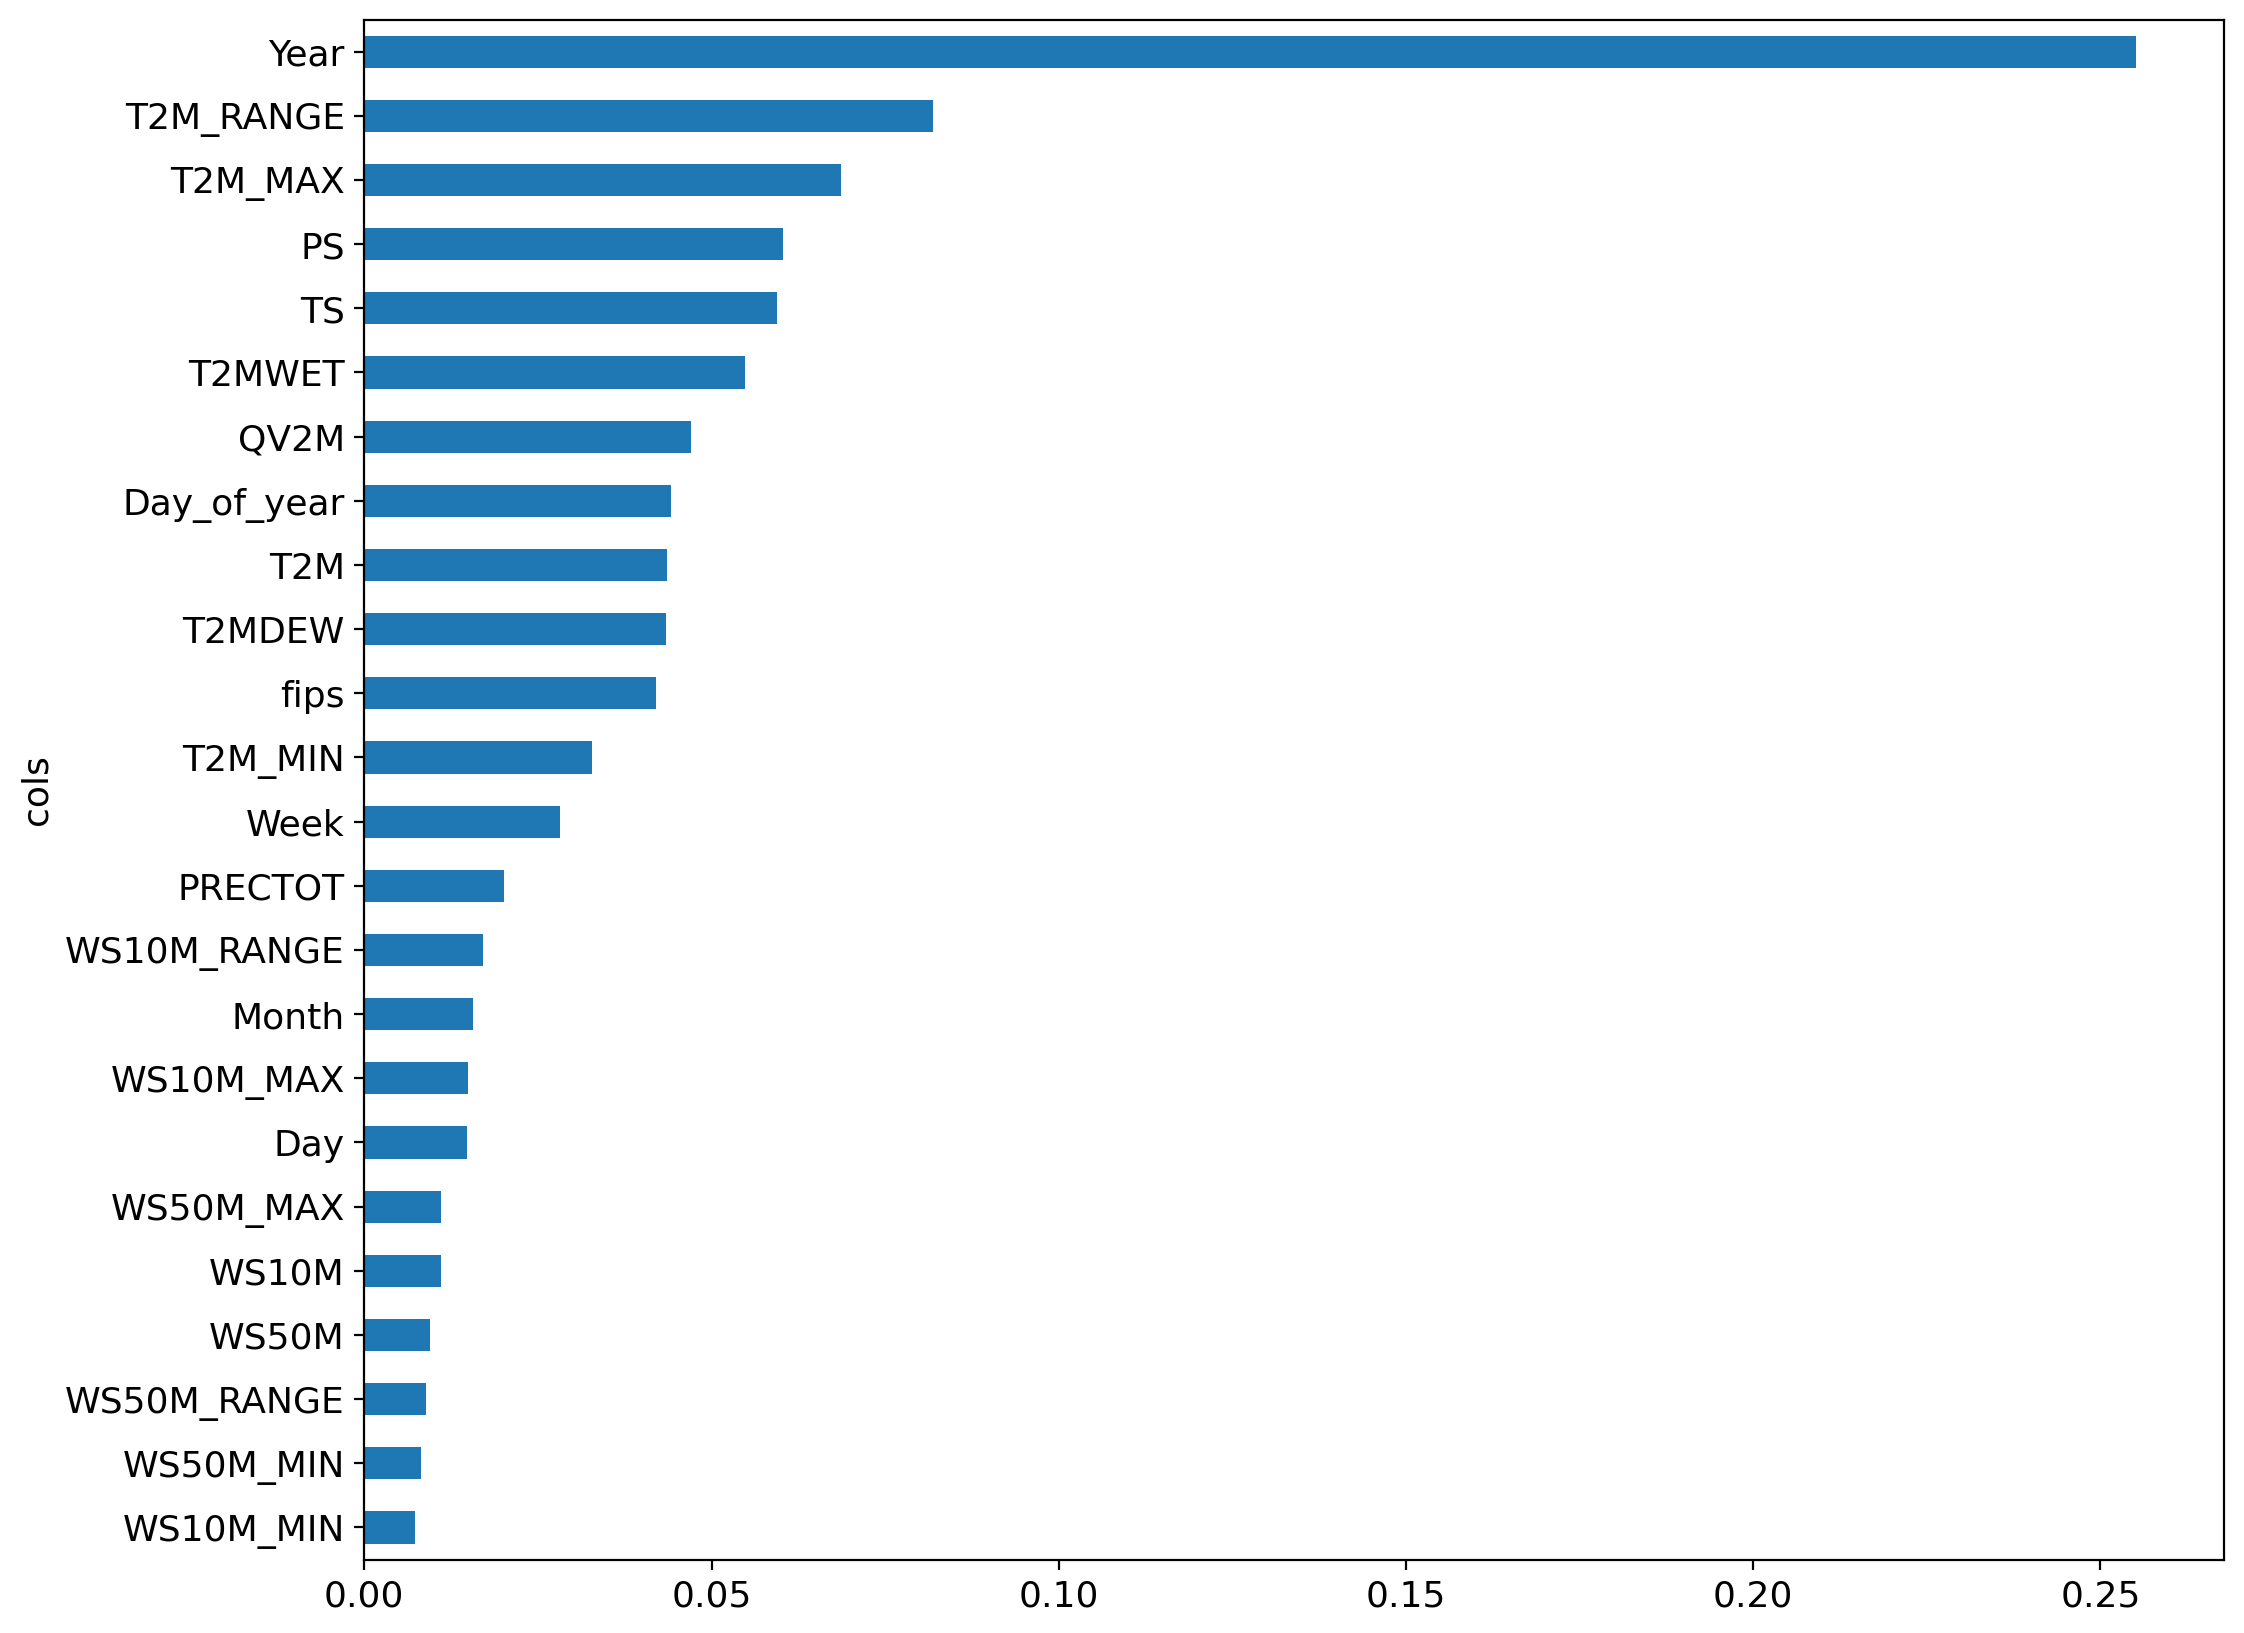

In [39]:
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

In [43]:
to_keep = feat_importance[feat_importance.imp > 0.02].cols
len(to_keep)

14

In [44]:
to_keep

19           Year
9       T2M_RANGE
7         T2M_MAX
2              PS
10             TS
6          T2MWET
3            QV2M
23    Day_of_year
4             T2M
5          T2MDEW
0            fips
8         T2M_MIN
21           Week
1         PRECTOT
Name: cols, dtype: object

## The Random Forest with the most important feature

In [57]:
df_keep = df[to_keep].copy()

In [60]:
# Split data into X and y

X_train_df, y_train_df = df_train[to_keep], df_train.score
X_valid_df, y_valid_df = df_val[to_keep], df_val.score
X_test_df, y_test_df = df_test[to_keep], df_test.score

X_newtest_df, y_newtest_df = df_newtest[to_keep], df_newtest.score

# Check the shape of our X and y variables
X_train_df.shape, y_train_df.shape, X_valid_df.shape, y_valid_df.shape,X_test_df.shape, y_test_df.shape, X_newtest_df.shape, y_newtest_df.shape

((484302, 14),
 (484302,),
 (56784, 14),
 (56784,),
 (57330, 14),
 (57330,),
 (139755, 14),
 (139755,))

In [61]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df = (X_train_df - mean)/std
X_valid_df = (X_valid_df - mean)/std
X_test_df  = (X_test_df - mean)/std
X_newtest_df  = (X_newtest_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

X_valid = X_valid_df.to_numpy()
y_valid = y_valid_df.to_numpy()

X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

X_newtest = X_newtest_df.to_numpy()
y_newtest = y_newtest_df.to_numpy()

X_train.shape,y_train.shape,X_valid.shape,y_valid.shape, X_test.shape,y_test.shape, X_newtest.shape,y_newtest.shape

((484302, 14),
 (484302,),
 (56784, 14),
 (56784,),
 (57330, 14),
 (57330,),
 (139755, 14),
 (139755,))

In [ ]:
random_grid4 = {'n_estimators': [15,20,30,45,60],
               'max_features':[None,'sqrt'], 
               'max_depth':[None,10, 20, 25],
               'min_samples_leaf':[3,7,10,16],
               'max_samples':[None,0.5,0.25],
               'min_samples_split':[2,5,10,15,25],           
             }

In [62]:
class4 = RandomForestClassifier(random_state=42)

rf_random4 = RandomizedSearchCV(estimator = class4, param_distributions = random_grid4, 
                                n_iter = 5, cv = 3, verbose=2, n_jobs = -1)

%time rf_drought4 = rf_random4.fit(X_train,y_train)

print("The best hyperparameters: \n",rf_drought4.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
CPU times: user 28.1 s, sys: 407 ms, total: 28.5 s
Wall time: 3min 47s
The best hyperparameters: 
 {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_samples': None, 'max_features': 'sqrt', 'max_depth': None}


In [64]:
model_rf_features = rf_drought4.best_estimator_
model_rf_features

RandomForestClassifier(max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=5, n_estimators=30, random_state=42)

In [ ]:
print_score(model_rf_features, X_train, y_train, X_test, y_test)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

class_names=[0,1,2,3,4,5]

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", "true")]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model_rf_features,
        X_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

plt.show()